# Tarea 3 - Deep learning

* Fecha : primavera 25 Octubre de 2024.
* Autor : Allen Josehp Arroyo Garrido.

Usamos un dataset pequeñito de analisis de sentimiento en tweets. Cada tweet viene con una etiqueta entre `positive`, `negative` y `neutral`.

**Vamos a ver como usar:**
* Utilizar una representacion de word embedding ya entrenada
* Utilizar estes representaciones con MLP y un RNN
* Comparar con un RNN que va apprende su capa de embeddings
* Utilizar un modelo pre-entrenado contextual como BERT

## Se puede utilizar LLM para ayudarse!
Mirar a [un ejemplo](https://chatgpt.com/share/d534833e-bd2c-40c1-81eb-34818b195cac) de como pedir las respuestas a un LLM. Mejor si entenden lo que hagan.

#### Para cada entrenamiento
* Informa de las curvas de pérdida y precisión en el entrenamiento y la validación.
* Detén el entrenamiento en función de los resultados obtenidos en el conjunto de validación.
* Utiliza una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las distintas curvas.  

### Before Starting! Some tips on GPU and Google Colab

You will likely to run this code on Google Colab in order to use GPU ressources. If not, the code will take 60 times more to run!!  


(Es probable que tenga que ejecutar este código en Google Colab para utilizar los recursos de la GPU. Si no, el código tardará 60 veces más en ejecutarse.)

#### Stop disconnection

Colab will disconnect you if you the training is too long. In order to prevent this, you can use this piece of code in the console of your browser:

 (Colab will disconnect you if you the training is too long. In order to prevent this, you can use this piece of code in the console of your browser: )

```java
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

See more [here](https://www.reddit.com/r/StableDiffusion/comments/xhhlp0/automatic1111_on_colab_how_to_keep_it_running/).

#### Other account

If you run out of available ressources, what you can do is changing of the account you are using in colab. You can create another gmail and switch to it, this should give you more GPU ressources.

Have fun!

In [ ]:
! wget https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Texts.zip
! unzip Texts.zip

--2024-10-22 01:02:59--  https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Texts.zip
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143512 (140K) [application/zip]
Saving to: ‘Texts.zip’

Texts.zip           100%[===================>] 140.15K   306KB/s    in 0.5s    

2024-10-22 01:03:00 (306 KB/s) - ‘Texts.zip’ saved [143512/143512]

Archive:  Texts.zip
  inflating: MModal_Sentiment_dev.tsv  
  inflating: MModal_Sentiment_test.tsv  
  inflating: MModal_Sentiment_train.tsv  


In [ ]:
import pandas as pd

def read_data(fn):
    df = pd.read_csv(fn, sep='\t')[['tweet', 'label']]
    X = df.tweet
    y = df.label
    return X, y

split='train'
X_train, y_train = read_data('MModal_Sentiment_%s.tsv'%split)
split='dev'
#  Son los datos de desarrollo o datos de validación, que se utilizan para evaluar el rendimiento del modelo mientras se entrena.
X_dev, y_dev = read_data('MModal_Sentiment_%s.tsv'%split)
split='test'
# Son los datos de prueba o test, que se usan para la evaluación final del modelo después de que ha sido entrenado
X_test, y_test = read_data('MModal_Sentiment_%s.tsv'%split)

In [ ]:
y_dev[0]

'neutral'

In [ ]:
X_train[0:20]

,tweet
0,Me as John Lennon .
1,RT @ BBC Travel : Chasing light and shadows in...
2,RT @ BI Defense : Britain scrambles Typhoon je...
3,UNCTAD tells # Congobrazza to do more to attra...
4,RT @ ESPN FirstTake : I think he should STAY i...
5,. @ TheSwonBrothers @ SwonBrothers Performing ...
6,"RT @ nytimes : A French take on tagine , from ..."
7,RT @ business : Apple is now almost twice as v...
8,RT @ barrabest : A great photo of # Belfast Ci...
9,This is a fantastic idea - a purifying wave po...


In [ ]:
y_train[0:20]

,label
0,positive
1,positive
2,neutral
3,neutral
4,neutral
5,neutral
6,neutral
7,positive
8,positive
9,neutral


## Word2vec

Construir una funcion que va a representar un texto. Utilizamos `'glove-twitter-25'` porque es el mas pequeño. Pueden probar con otros modelos mas grandes!


'glove-twitter-25' es un modelo preentrenado de word embeddings basado en el algoritmo GloVe (Global Vectors for Word Representation). Este modelo ha sido entrenado en tweets de Twitter y cada palabra se representa como un vector de 25 dimensiones

In [ ]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
wv_string = 'glove-twitter-25'
# wv_string = 'glove-twitter-200'
# wv_string = 'word2vec-google-news-300'

wv = gensim.downloader.load(wv_string)

[==================================================] 100.0% 104.8/104.8MB downloaded


Visualizamos el vector de la palabra *computer*, y cuales son las palabras de los vectores los mas similares en el espacio utilizando la distancia cosinus

La distancia coseno (o similitud coseno) es una métrica que se utiliza para medir la similitud entre dos vectores en un espacio de alta dimensión. En el contexto de word embeddings, como los generados por modelos como GloVe, se usa para comparar qué tan similares son los vectores que representan diferentes palabras.

In [ ]:
wv['computer'], wv.most_similar('computer')

(array([ 0.64005 , -0.019514,  0.70148 , -0.66123 ,  1.1723  , -0.58859 ,
         0.25917 , -0.81541 ,  1.1708  ,  1.1413  , -0.15405 , -0.11369 ,
        -3.8414  , -0.87233 ,  0.47489 ,  1.1541  ,  0.97678 ,  1.1107  ,
        -0.14572 , -0.52013 , -0.52234 , -0.92349 ,  0.34651 ,  0.061939,
        -0.57375 ], dtype=float32),
 [('camera', 0.907833456993103),
  ('cell', 0.891890287399292),
  ('server', 0.874466598033905),
  ('device', 0.8693525195121765),
  ('wifi', 0.863125741481781),
  ('screen', 0.8621907234191895),
  ('app', 0.8615543246269226),
  ('case', 0.8587921857833862),
  ('remote', 0.8583616018295288),
  ('file', 0.8575270771980286)])

In [ ]:
wv['wifi'], wv.most_similar('wifi')

(array([ 1.0436   ,  0.34963  ,  0.53401  , -0.50679  ,  0.99889  ,
         0.37622  , -0.17858  ,  0.34774  ,  0.59996  ,  1.4162   ,
         0.0070862, -0.96253  , -2.5824   , -0.68466  ,  0.44308  ,
         0.89373  ,  0.98579  ,  0.050084 , -0.060701 , -0.29792  ,
        -0.38006  , -1.0661   ,  0.60984  ,  0.40913  , -0.30669  ],
       dtype=float32),
 [('internet', 0.8913102149963379),
  ('laptop', 0.8758924603462219),
  ('wi-fi', 0.8637332320213318),
  ('computer', 0.8631256818771362),
  ('ipod', 0.857280433177948),
  ('blackberry', 0.8542298674583435),
  ('iphone', 0.8486185073852539),
  ('windows', 0.8356131315231323),
  ('charger', 0.8313565850257874),
  ('cell', 0.8292644619941711)])

### Transform the docs into sequences of embeddings

We take the word-vectors of each of the words in the sentence, so for each sentence we get a sequence of vectors

( Transformar los documentos en secuencias de incrustaciones.
Tomamos los vectores palabra de cada una de las palabras de la frase, de modo que para cada frase obtenemos una secuencia de vectores)

In [ ]:
wv[0], wv[200],len(wv)

(array([ 0.62415 ,  0.62476 , -0.082335,  0.20101 , -0.13741 , -0.11431 ,
         0.77909 ,  2.6356  , -0.46351 ,  0.57465 , -0.024888, -0.015466,
        -2.9696  , -0.49876 ,  0.095034, -0.94879 , -0.017336, -0.86349 ,
        -1.3348  ,  0.046811,  0.36999 , -0.57663 , -0.48469 ,  0.40078 ,
         0.75345 ], dtype=float32),
 array([-0.32909,  0.40221, -0.81   , -0.37379, -0.91075, -1.4961 ,
         1.7134 ,  0.90296, -0.93052,  0.23089, -0.30272, -0.23206,
        -4.2977 , -0.94941, -0.27274,  0.1943 , -0.19176, -1.6868 ,
        -0.40934, -0.53334, -0.27725, -0.86553, -0.16371,  0.89115,
        -0.74183], dtype=float32),
 1193514)

In [ ]:
 wv.index_to_key[0:20]

['<user>',
 '.',
 ':',
 'rt',
 ',',
 '<repeat>',
 '<hashtag>',
 '<number>',
 '<url>',
 '!',
 'i',
 'a',
 '"',
 'the',
 '?',
 'you',
 'to',
 '(',
 '<allcaps>',
 '<elong>']

In [ ]:
vocabulary = wv.index_to_key
'''
Si documents = ["I love programming", "This is a test"]
from_wd_to_vec(documents) hará lo siguiente para la  1era palabra:
Lo convertirá a minúsculas: "i love programming"
Lo dividirá en palabras: ["i", "love", "programming"]
calculará el vector de cada palabra asociada en wv
'''
def from_wd_to_vec(documents):
    documents_wvs = [
        [wv[word] for word in document.lower().split() if word in vocabulary] # Si una palabra no está en el vocabulario, se ignora.
        for document in documents
    ]
    return documents_wvs

In [ ]:
n_train,n_dev,n_test = len(X_train),len(X_dev),len(X_test)
n_train,n_dev,n_test

(1888, 643, 604)

In [ ]:
# TODO: Create the representations
# Tenemos X_train, y_train, X_dev, y_dev, X_test, y_test

X_train_wv = from_wd_to_vec(X_train)
X_dev_wv = from_wd_to_vec(X_dev)
X_test_wv = from_wd_to_vec(X_test)

In [ ]:
X_train[0]

'Me as John Lennon .'

In [ ]:
X_train[0],X_train_wv[0],len(X_train_wv[0]),y_train[0],len(X_train_wv)

('Me as John Lennon .',
 [array([ 0.58866  ,  0.0060408, -0.22022  ,  1.0119   , -0.7583   ,
          0.12081  , -0.025355 ,  1.596    , -1.521    , -1.1867   ,
         -0.42468  , -2.0128   , -5.3977   , -1.2343   ,  0.17889  ,
          1.3491   , -0.011538 , -0.063358 , -0.18676  , -0.18863  ,
          0.81819  , -0.33465  ,  1.6392   ,  1.4183   ,  0.16919  ],
        dtype=float32),
  array([ 1.6188  , -1.1035  ,  0.42658 ,  0.31703 , -0.11402 ,  0.59275 ,
          0.49999 , -0.69629 ,  0.41089 , -1.3685  , -0.31823 , -1.1131  ,
         -5.152   ,  0.19204 , -0.42396 , -0.51919 , -0.80009 , -0.17698 ,
         -0.51131 , -0.85695 ,  0.093274,  0.33135 , -0.28833 , -0.14587 ,
         -0.62965 ], dtype=float32),
  array([-0.26313, -0.24609,  0.61913,  0.44674, -0.77468, -0.5529 ,
          0.1107 ,  0.8918 ,  0.19167, -1.2746 ,  0.4818 ,  0.38438,
         -3.9371 , -0.5584 ,  0.94749, -0.81232, -0.27328,  0.53896,
         -0.16349, -0.31345, -0.08761,  0.60651, -0.92633, -0.

#### Visualizacion

Visualiza los vectores en 2D con sus labeles. Usa T-SNE o UMAP

* Para tener un unico vector representando una frase, se puede agregar los vectores de cada palabra tomando en promedio de los vectores

Por ejemplo utilizando:
```python
documents_wv = [np.mean(list_wv_sent, axis=0) for list_wv_sent in documents_wvs]
```

In [ ]:
!pip install umap-learn
#!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
import umap
from matplotlib import patches

In [ ]:
# TODO: Visualization

X_train_wv_mean = [np.mean(list_wv_sent, axis=0) for list_wv_sent in X_train_wv ]
X_test_wv_mean = [np.mean(list_wv_sent, axis=0) for list_wv_sent in X_test_wv ]
X_dev_wv_mean = [np.mean(list_wv_sent, axis=0) for list_wv_sent in X_dev_wv ]

In [ ]:
# Ejemplos:
X_train_wv_mean[0], len(X_train_wv_mean), X_dev_wv_mean[10]

(array([ 0.43040198, -0.5540479 ,  0.256768  ,  0.5524918 , -0.57458025,
         0.12632799,  0.3685368 ,  0.86368   , -0.450776  , -0.82782   ,
         0.18873797, -0.63057   , -3.9325001 , -0.23851803,  0.33184603,
        -0.15057601, -0.4649096 ,  0.12242439, -0.256108  , -0.51491004,
         0.21980238,  0.26319999, -0.192252  ,  0.17211202, -0.075214  ],
       dtype=float32),
 1888,
 array([-0.00701002,  0.27276856,  0.19470756, -0.34204176, -0.26913166,
         0.07719868,  0.9194922 ,  0.5981778 ,  0.2097011 ,  0.14213668,
        -0.02697322, -0.03686503, -4.1872554 , -0.07373334,  0.15019311,
        -0.44822115,  0.01130588, -0.35905644, -0.5308306 , -0.27672002,
        -0.21003823, -0.28275484,  0.11583356, -0.29663733,  0.45533222],
       dtype=float32))

In [ ]:
# Función para visualizar los arreglos en 2D

def plot_2d_projection(X, y, title):
    plt.figure(figsize=(8, 8))
    unique_labels = np.unique(y)

    palette = sns.color_palette("hsv", len(unique_labels)) # Colores para las etiquetas

    for i, label in enumerate(unique_labels):
        indices = np.where(np.array(y) == label)
        plt.scatter(X[indices, 0], X[indices, 1], label=label, color=palette[i], alpha=0.6)

    plt.legend(loc='best')
    plt.title(title)
    plt.show()

X_2d = np.concatenate([X_train_wv_mean, X_dev_wv_mean, X_test_wv_mean], axis=0)
y_2d = np.concatenate([y_train, y_dev, y_test])

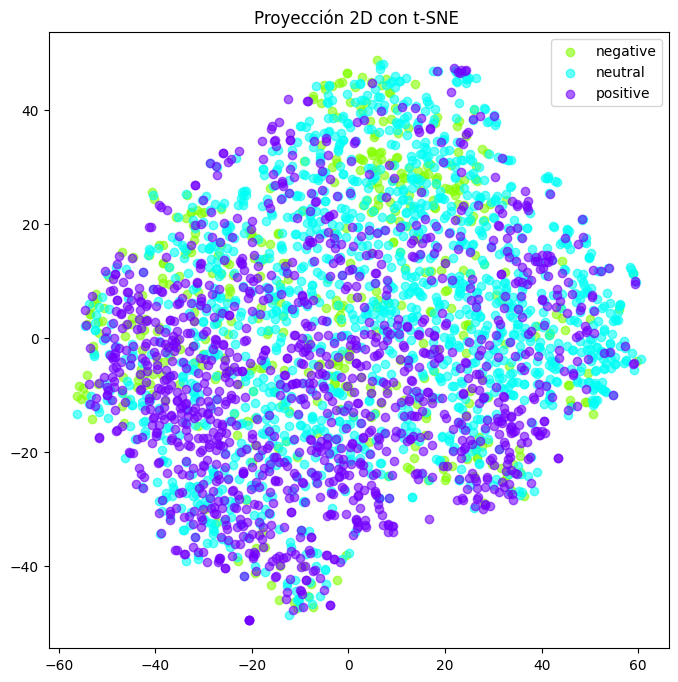

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


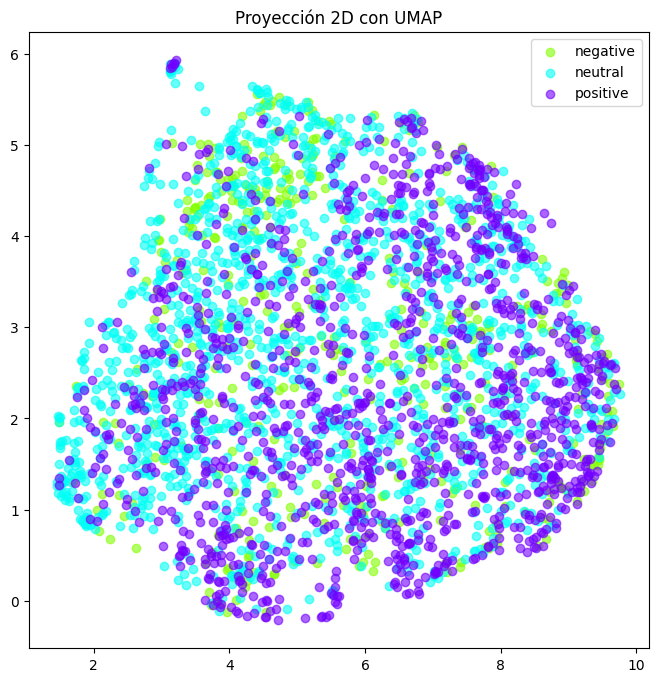

In [ ]:
# Dado: t-SNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_2d)
plot_2d_projection(X_tsne, y_2d, "Proyección 2D con t-SNE ")

# Dado: UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_2d)
plot_2d_projection(X_umap, y_2d, "Proyección 2D con UMAP")

## Modelizacion

**Metricas**: Para este tarea de clasificacion pueden utilizar el score F-1 para estimar las performancias de los modelos  

### Multi-Layer Perceptron

El MLP solo toma un vector en entrada, no una secuencia de vectores, por eso tenemos que agregar los vectores de las palabras de una sentencia en uno.  

* Aggreg the word vectors of each doc to get one vector per doc
(Agregue los vectores de palabras de cada documento para obtener un vector por documento.)

* Learn a MLP


#### Para cada entrenamiento
* Informa de las curvas de pérdida y precisión en el entrenamiento y la validación.
* Detén el entrenamiento en función de los resultados obtenidos en el conjunto de validación.
* Utiliza una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las distintas curvas.  


Entonces vamos a trabajar con (Mean Pooling), i.e, tomaremos el promedio de los vectores de las palabras en cada frase.



```
X_train_wv_mean, X_dev_wv_mean, X_test_wv_mean
```



In [ ]:
# documents_wv_aggreg = [np.mean(document, axis=0) for document in documents_wv]

In [ ]:
# Recuerdo que ya tenemos un arreglos que guardan para cada dato un vector.

X_train_wv_mean[0],n_train,n_dev,n_test

(array([ 0.43040198, -0.5540479 ,  0.256768  ,  0.5524918 , -0.57458025,
         0.12632799,  0.3685368 ,  0.86368   , -0.450776  , -0.82782   ,
         0.18873797, -0.63057   , -3.9325001 , -0.23851803,  0.33184603,
        -0.15057601, -0.4649096 ,  0.12242439, -0.256108  , -0.51491004,
         0.21980238,  0.26319999, -0.192252  ,  0.17211202, -0.075214  ],
       dtype=float32),
 1888,
 643,
 604)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import numpy as np

In [ ]:
# Parámetros :
input_size = 25  # Tamaño de los vectores (embeddings) = 25
hidden_size = 64  # Numero de neuronas en la capa oculta
output_size = 3  # Numero de clases (positive, neutral, negative)

num_epochs = 100  # Numero de épocas
batch_size = 25  # Tamaño del batch

learning_rate = 0.001  # Tasa de aprendizaje

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definimos la MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
# Codificar etiquetas, pues en un inicio tenemos string's : "neutral,positive,negative"

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)

# DataLoader para los conjuntos de datos
train_dataset = TensorDataset(torch.FloatTensor(X_train_wv_mean), torch.LongTensor(y_train_encoded))
dev_dataset = TensorDataset(torch.FloatTensor(X_dev_wv_mean), torch.LongTensor(y_dev_encoded))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=False)

# Inicializa el modelo, la función de perdida y el optimizador. (Luego quizas redefinir el nombre del modelo )
model = MLP(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#arreglos para almacenar estadisticas
train_losses = []
dev_losses = []
dev_accuracies = []
f1_scores = []

<ipython-input-27-062732d9a213>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  train_dataset = TensorDataset(torch.FloatTensor(X_train_wv_mean), torch.LongTensor(y_train_encoded))


In [ ]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        # Reinicia los gradientes

        # Hace la predicción
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # backpropagation y optimización
        loss.backward()
        optimizer.step()

    # Calcular el train_loss promedio
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluación en el conjunto de validación(dev)
    model.eval()
    total_dev_loss = 0
    correct = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_dev_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Almacena las predicciones y etiquetas verdaderas para el F1 score
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcula la pérdida y precisión en el conjutno de validacion
    dev_loss = total_dev_loss / len(dev_loader)
    dev_accuracy = correct / len(dev_dataset)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_accuracy)

    f1 = f1_score(all_labels, all_predictions, average='weighted')     # Calcula el F1 score
    f1_scores.append(f1)  # Almacena el F1 score

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Dev Loss: {dev_loss:.4f}, Dev Accuracy: {dev_accuracy:.4f}, F1 Score: {f1:.4f}')


Epoch [1/100], Train Loss: 0.9998, Dev Loss: 0.9329, Dev Accuracy: 0.5910, F1 Score: 0.5378
Epoch [2/100], Train Loss: 0.9297, Dev Loss: 0.8955, Dev Accuracy: 0.5630, F1 Score: 0.5226
Epoch [3/100], Train Loss: 0.8980, Dev Loss: 0.8554, Dev Accuracy: 0.5910, F1 Score: 0.5507
Epoch [4/100], Train Loss: 0.8624, Dev Loss: 0.8340, Dev Accuracy: 0.5910, F1 Score: 0.5595
Epoch [5/100], Train Loss: 0.8431, Dev Loss: 0.8147, Dev Accuracy: 0.6143, F1 Score: 0.5976
Epoch [6/100], Train Loss: 0.8254, Dev Loss: 0.7999, Dev Accuracy: 0.6190, F1 Score: 0.6047
Epoch [7/100], Train Loss: 0.8182, Dev Loss: 0.7910, Dev Accuracy: 0.6190, F1 Score: 0.6069
Epoch [8/100], Train Loss: 0.8095, Dev Loss: 0.7869, Dev Accuracy: 0.6221, F1 Score: 0.6146
Epoch [9/100], Train Loss: 0.8043, Dev Loss: 0.7815, Dev Accuracy: 0.6236, F1 Score: 0.6130
Epoch [10/100], Train Loss: 0.8047, Dev Loss: 0.7864, Dev Accuracy: 0.6112, F1 Score: 0.6031
Epoch [11/100], Train Loss: 0.7975, Dev Loss: 0.7806, Dev Accuracy: 0.6283, F1 

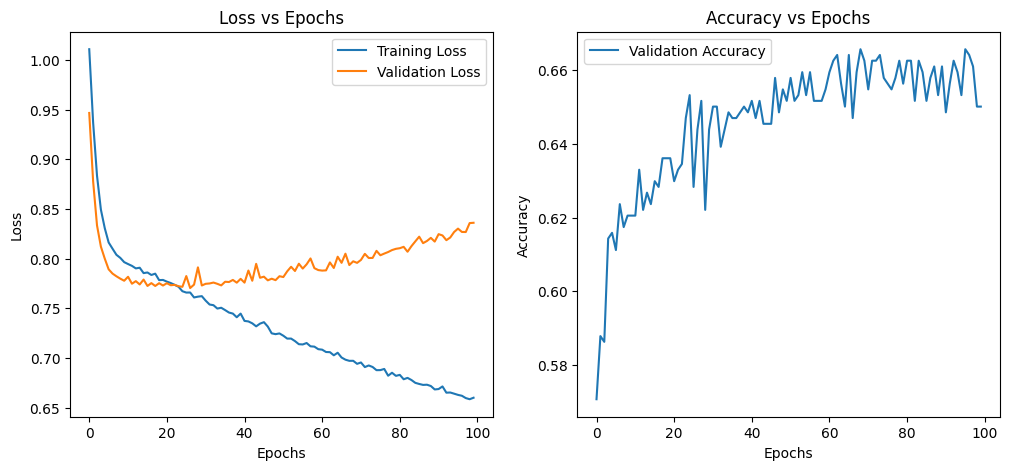

In [ ]:
# Visualización
plt.figure(figsize=(12, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(dev_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(dev_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()

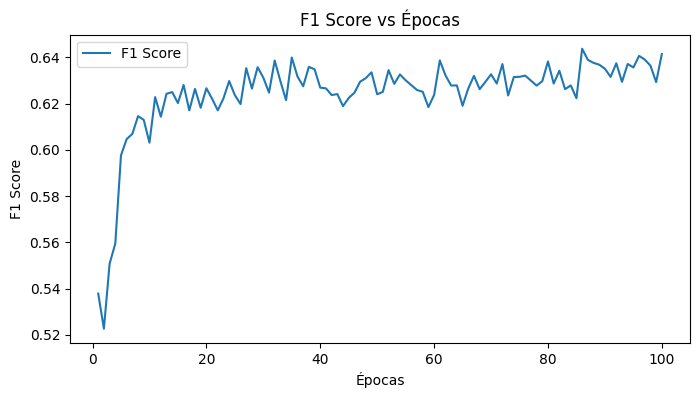

In [ ]:
# F1 score por cada epoca

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), f1_scores, label='F1 Score')
plt.xlabel('Épocas')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Épocas')
plt.legend()
#plt.grid(True)
plt.show()

In [ ]:
#Ahora evaluaremos en la data de test:

from sklearn.metrics import confusion_matrix, classification_report

# Antes me olvidé de crear este arreglo para X_test_wv_mean
test_dataset = TensorDataset(torch.FloatTensor(X_test_wv_mean), torch.LongTensor(y_test_encoded))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluamos en el conjunto test.
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Guarda las etiquetas reales y predichas para calcular metricas
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calcula el F1 score para el conjunto de test
test_f1_score = f1_score(all_labels, all_predictions, average='weighted')
print(f'Test F1 Score: {test_f1_score:.4f}')

# reporte :
print(classification_report(all_labels, all_predictions, target_names=['negative', 'neutral', 'positive']))

Test F1 Score: 0.6194
              precision    recall  f1-score   support

    negative       0.51      0.39      0.44        79
     neutral       0.67      0.62      0.64       285
    positive       0.61      0.70      0.65       240

    accuracy                           0.62       604
   macro avg       0.59      0.57      0.58       604
weighted avg       0.62      0.62      0.62       604



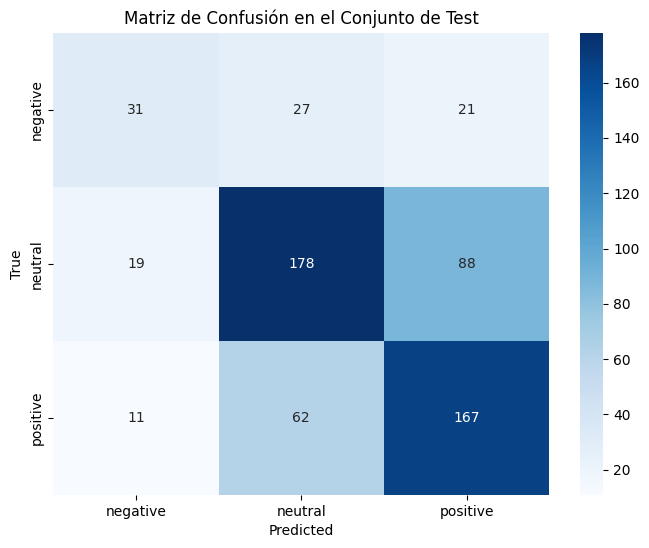

In [ ]:
# matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Matriz de Confusión en el Conjunto de Test para MLP')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()


### RNN-LSTM

RNN (Red Neuronal Recurrente): - LSTM (Long Short-Term Memory)

Las LSTMs son una mejora sobre las RNNs tradicionales, diseñadas para resolver este problema de desvanecimiento del gradiente y permitir el aprendizaje a largo plazo.

Use the sequences of wordvectors using a Recurrent Neural Network(Utilizar las secuencias de vectores de palabras mediante una red neuronal recurrente )

#### Para cada entrenamiento
* Informa de las curvas de pérdida y precisión en el entrenamiento y la validación.
* Detén el entrenamiento en función de los resultados obtenidos en el conjunto de validación.
* Utiliza una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las distintas curvas.  

In [ ]:
# TODO: RNN-LSTM
# recordemos que tenemos en los arreglos X_train_ws,.. arreglos para cada palabra de la frase
X_train[0],X_train_wv[0]

('Me as John Lennon .',
 [array([ 0.58866  ,  0.0060408, -0.22022  ,  1.0119   , -0.7583   ,
          0.12081  , -0.025355 ,  1.596    , -1.521    , -1.1867   ,
         -0.42468  , -2.0128   , -5.3977   , -1.2343   ,  0.17889  ,
          1.3491   , -0.011538 , -0.063358 , -0.18676  , -0.18863  ,
          0.81819  , -0.33465  ,  1.6392   ,  1.4183   ,  0.16919  ],
        dtype=float32),
  array([ 1.6188  , -1.1035  ,  0.42658 ,  0.31703 , -0.11402 ,  0.59275 ,
          0.49999 , -0.69629 ,  0.41089 , -1.3685  , -0.31823 , -1.1131  ,
         -5.152   ,  0.19204 , -0.42396 , -0.51919 , -0.80009 , -0.17698 ,
         -0.51131 , -0.85695 ,  0.093274,  0.33135 , -0.28833 , -0.14587 ,
         -0.62965 ], dtype=float32),
  array([-0.26313, -0.24609,  0.61913,  0.44674, -0.77468, -0.5529 ,
          0.1107 ,  0.8918 ,  0.19167, -1.2746 ,  0.4818 ,  0.38438,
         -3.9371 , -0.5584 ,  0.94749, -0.81232, -0.27328,  0.53896,
         -0.16349, -0.31345, -0.08761,  0.60651, -0.92633, -0.

**Observaciones**

Cuando se habla de **word embeddings**, nos referimos a **representaciones** densas de palabras en un espacio vectorial continuo. Cada palabra del vocabulario se representa como un vector de números en un espacio de dimensión fija. Ejemplos comunes de modelos de embeddings preentrenados son Word2Vec, GloVe, y FastText.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score,accuracy_score
from sklearn.preprocessing import LabelEncoder

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# Algunos datos para vizuaizar los objetos :
X_train_wv[0][0],len(X_train_wv[0][0]),len(X_train_wv)

(array([ 0.58866  ,  0.0060408, -0.22022  ,  1.0119   , -0.7583   ,
         0.12081  , -0.025355 ,  1.596    , -1.521    , -1.1867   ,
        -0.42468  , -2.0128   , -5.3977   , -1.2343   ,  0.17889  ,
         1.3491   , -0.011538 , -0.063358 , -0.18676  , -0.18863  ,
         0.81819  , -0.33465  ,  1.6392   ,  1.4183   ,  0.16919  ],
       dtype=float32),
 25,
 1888)

# Construimos la RNN-LSTMSentimentClassifier

In [ ]:

#  modelo LSTM
class LSTMSentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.3):
        super(LSTMSentimentClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # funcion de activacion
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)
        # Solo toma la salida del ultimo paso de tiempo
        lstm_out = lstm_out[:, -1, :]
        # pasa por la capa fully connected y aplica sofmax
        out = self.fc(lstm_out)
        return self.softmax(out)

# Parámetros del modelo
input_dim = 25  # dimensión del vector de GloVe (glove-twitter-25)
hidden_dim = 128
output_dim = 3  # tres clases: neutral, positive, negative
n_layers = 2
dropout = 0.3

# l Dropout es una técnica de regularización que se utiliza en redes neuronales para prevenir el sobreajuste (overfitting).
#  El parámetro dropout = 0.3 significa que durante cada iteración de entrenamiento,
# el 30% de las neuronas en la capa donde se aplica el dropout se desactivarán aleatoriamente (se "apagarán").

model = LSTMSentimentClassifier(input_dim, hidden_dim, output_dim, n_layers, dropout)


In [ ]:
def train_model(model, X_train_wv, y_train_encoded, X_dev_wv, y_dev_encoded, epochs, batch_size, lr):
    # optimizador y criterio
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Listas para almacenar las metricas
    train_losses = []
    dev_losses = []
    dev_accuracies = []
    f1_scores = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        # Entrenamiento por mini-batch
        for i in range(0, len(X_train_wv), batch_size):
            #X_batch = torch.tensor(X_train_wv[i:i+batch_size], dtype=torch.float32) # con esto tiraba un warning
            X_batch = X_train_wv[i:i+batch_size].clone().detach()
            y_batch = torch.tensor(y_train_encoded[i:i+batch_size], dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(X_train_wv))

        # Evaluación en conjunto dev
        model.eval()
        with torch.no_grad():
            #X_dev = torch.tensor(X_dev_wv, dtype=torch.float32) # con esto tiraba un warning
            X_dev = X_dev_wv.clone().detach()
            y_dev = torch.tensor(y_dev_encoded, dtype=torch.long)

            dev_outputs = model(X_dev)
            dev_loss = criterion(dev_outputs, y_dev).item()
            dev_losses.append(dev_loss)

            # Calcular accuracy y F1-score en dev
            _, predicted = torch.max(dev_outputs, 1)
            accuracy = accuracy_score(y_dev, predicted)
            dev_accuracies.append(accuracy)

            f1 = f1_score(y_dev, predicted, average='weighted')
            f1_scores.append(f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Dev Loss: {dev_losses[-1]:.4f}, Dev Acc: {dev_accuracies[-1]:.4f}, F1 Score: {f1_scores[-1]:.4f}")

    return train_losses, dev_losses, dev_accuracies, f1_scores


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Ejemplo:
y_test_encoded[0:10]

array([1, 2, 1, 1, 1, 2, 1, 2, 1, 1])

In [ ]:
# Convierte cada frase en una lista de tensores de palabras

X_train_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in X_train_wv]
X_dev_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in X_dev_wv]
X_test_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in X_test_wv]

# padding: generamos que todas las secuencias tengan la misma longitud
X_train_padded = pad_sequence(X_train_tensors, batch_first=True)
X_dev_padded = pad_sequence(X_dev_tensors, batch_first=True)
X_test_padded = pad_sequence(X_test_tensors, batch_first=True)

# despues del padding tenemos :
print(X_train_padded.shape)  # (batch_size, max_seq_length, embedding_dim)

torch.Size([1888, 34, 25])


In [ ]:
epochs = 20
batch_size = 32
lr =0.0001

# Entrenamos el modelo
train_losses, dev_losses, dev_accuracies, f1_scores = train_model(model, X_train_padded, y_train_encoded, X_dev_padded, y_dev_encoded, epochs, batch_size, lr)

Epoch 1/20, Train Loss: 0.0336, Dev Loss: 1.0405, Dev Acc: 0.4883, F1 Score: 0.3205
Epoch 2/20, Train Loss: 0.0325, Dev Loss: 1.0019, Dev Acc: 0.4883, F1 Score: 0.3205
Epoch 3/20, Train Loss: 0.0320, Dev Loss: 0.9969, Dev Acc: 0.4883, F1 Score: 0.3205
Epoch 4/20, Train Loss: 0.0319, Dev Loss: 0.9950, Dev Acc: 0.4883, F1 Score: 0.3205
Epoch 5/20, Train Loss: 0.0318, Dev Loss: 0.9912, Dev Acc: 0.4883, F1 Score: 0.3205
Epoch 6/20, Train Loss: 0.0314, Dev Loss: 0.9668, Dev Acc: 0.4914, F1 Score: 0.4085
Epoch 7/20, Train Loss: 0.0307, Dev Loss: 0.9443, Dev Acc: 0.4790, F1 Score: 0.4319
Epoch 8/20, Train Loss: 0.0303, Dev Loss: 0.9248, Dev Acc: 0.4868, F1 Score: 0.4506
Epoch 9/20, Train Loss: 0.0300, Dev Loss: 0.9110, Dev Acc: 0.5179, F1 Score: 0.4805
Epoch 10/20, Train Loss: 0.0296, Dev Loss: 0.9039, Dev Acc: 0.5381, F1 Score: 0.5122
Epoch 11/20, Train Loss: 0.0294, Dev Loss: 0.9004, Dev Acc: 0.5412, F1 Score: 0.5358
Epoch 12/20, Train Loss: 0.0292, Dev Loss: 0.8967, Dev Acc: 0.5443, F1 Sco

Tenemos guardos los arreglos
```
    train_losses
    dev_losses
    dev_accuracies
    f1_scores
```



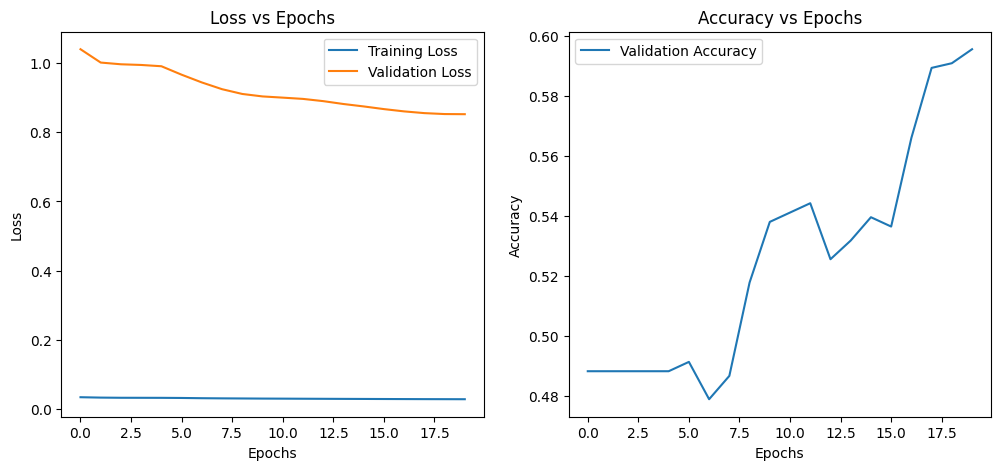

In [ ]:
# Visualización :
plt.figure(figsize=(12, 5))

# loss :
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(dev_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

# accuracy :
plt.subplot(1, 2, 2)
plt.plot(dev_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()

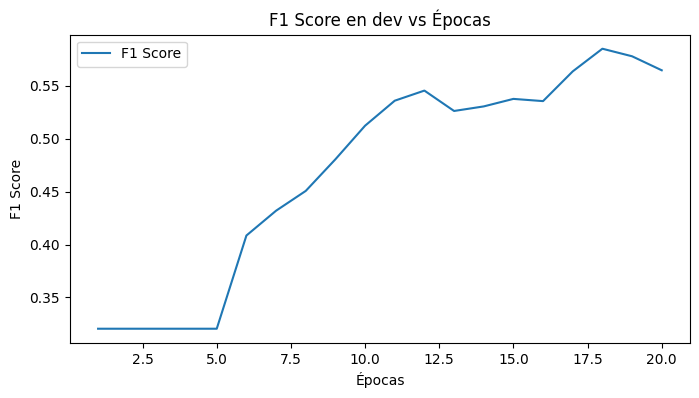

In [ ]:
# F1 score por cada epoca

plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), f1_scores, label='F1 Score')
plt.xlabel('Épocas')
plt.ylabel('F1 Score')
plt.title('F1 Score en dev vs Épocas')
plt.legend()
#plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Crea el DataLoader para el conjunto test
test_dataset = TensorDataset(X_test_padded, torch.LongTensor(y_test_encoded))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluar el modelo en el conjunto test
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # mover a GPU o CPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Guardar las etiquetas reales y predichas para luego calcular metricas
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Imprimir el reporte de clasificación
print(classification_report(all_labels, all_predictions, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.67      0.03      0.05        79
     neutral       0.53      0.55      0.54       285
    positive       0.55      0.70      0.62       240

    accuracy                           0.54       604
   macro avg       0.58      0.43      0.40       604
weighted avg       0.56      0.54      0.51       604



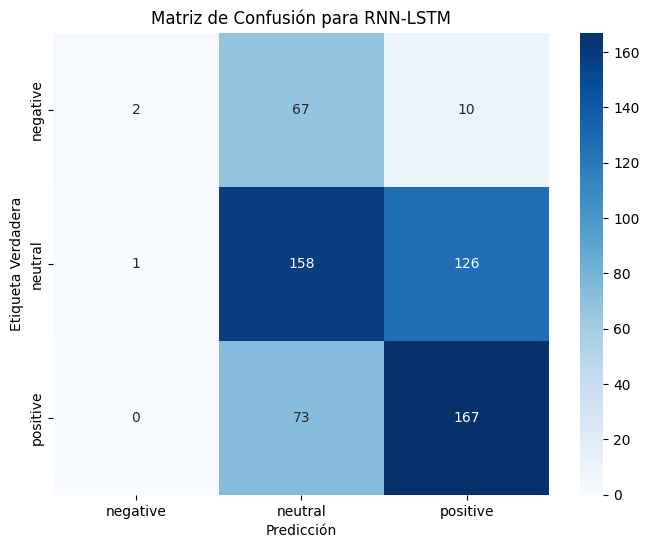

In [ ]:
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2])

# Visualización :
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Matriz de Confusión para RNN-LSTM')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()


### Preguntas

* Cuál es la ventaja de la modelización con RNN sobre MLP al usar una agregación de word embeddings?

Dadas los modelos en este caso no existe una diferencia relevante entre la MLP y la RNN con respecto a la información entregada en la matriz de confución. De hecho para la MLP en el conjunto de validación el F1-Score fue de 0.64 a diferencia del 0.56 de la RNN.  Más detalles de ventajas teoricas en la siguiente pregunta.

* Cuál es el beneficio de inicializar el RNN con los word embeddings de Word2Vec?

Dada la teoria lo que produce este metodo debiese ser un mejor entendimiento de de la RNN sobre las relaciones entre palabras, respeto del contexto entre ellas al utilizarlas y la semantica, pues al pasar a un espacio de vectores, palabras relacionadas entre sí serán vectores cercanos entre sí. Estos vectores además fueron generadors en un conjunto grande de datos, cosa que ayuda si presentamos un conjunto pequeño de entrenamiento.

Y dado que los vectores de palabras ya viene con ciertas relaciones de aproximación de distancia, entonces el modelo no necesita aprender desde 0.

* Como se comparan los entrenamientos de los diferentes modelos?

En entrenamiento de la RNN es notorio el overfitting, pues el loss en la data de entrenamiento desde un inicio es muy baja, por otro lado el accuracy en la data de validación crece considerablemente en ciertas epocas y luego se mantiene estable en un intervalo o incluso decae.

Por otro lado en la MLP el training loss en un momento decae con tendecia lineal, mientras que su validation loss aumenta, el accuracy en la data de validación aumenta pero con oscilaciones en las epocas.

* Como se comparan los resultados de los diferentes modelos?

Ambos modelos tiene el mejor desempeño(analizando la matriz de confusión) en la data de test en los casos 'neutral' y 'positive'. Los errores se producen en asignar como  'positive' textos que son 'neutral'.

La RNN nunca falla en asignar un 'negative' como 'positive', mientras que la MLP posee 11 errores. Ambos modelos poseen pocos aciertos para la etiqueta 'negative',quizás el dataset de estudio posee pocas etiquetas negaticas(investigar), en ambos modelos y con mayor cantidad en el RNN la etiqueta 'negative' es predecida como 'neutral'.



* Qué podemos ver con modelos de embedding mas grandes (complejos)?

Dada la información encontrada en modelos como ELMo, BERT y GPT podemos ver contextualizaciones, esto significa, que estos modelos generan representaciones diferentes para la misma palabra dependiendo del contexto de la frase aumentado la capacidad de capturar sentimientos e ideas. También un modelo más complejo puede tener dimensiones mayores como GloVe (Global Vectors for Word Representation), que ayudan a contribuir en una mayor precisión para representar palabras.


## BERT

Use a pre-trained BERT from the HuggingFace library and fine-tune it on the dataset.

* For the data, you can use the classes `Dataset` and `DataLoader` from `torch.utils.data`
* For the modelization:
  * You can use the classes `BertTokenizer` and `BertForSequenceClassification` from the `transformers` library
  * Load the weights of the models already pre-trained, with the associated tokenizer!
  * You can use a [classical bert](https://huggingface.co/bert-base-uncased) `'bert-base-uncased'`  
  * You can also use another model from huggingface, like [a smaller model](https://huggingface.co/distilbert-base-uncased) such as `distilbert-base-uncased` (it is an example)
* For the fine-tuning (optimization):
    * Make the loop in pytorch, **do not use** the class `Trainer` from the `transformers` library
    * You can use classical loss functions like cross-entropy and the optimizer you want, `Adam` or `AdamW` for example.
    * Reports the loss and accuracy curves on the train and validation
    * Stop the training regarding the performances obtained on the validation set
    * Use a small learning rate so you can see the loss going down on the different curves  


Utilice un BERT entrenado previamente de la biblioteca HuggingFace y ajústelo en el conjunto de datos.

* Para los datos, puede utilizar las clases `Dataset` y `DataLoader` de `torch.utils.data`
* Para la modelización:
 *  Puede utilizar las clases `BertTokenizer` y `BertForSequenceClassification` de la biblioteca `transformers`
 * ¡Cargue los pesos de los modelos ya entrenados previamente, con el tokenizador asociado!
 * Puedes usar un [bert clásico](https://huggingface.co/bert-base-uncased) `'bert-base-uncased'`
 * También puedes usar otro modelo de huggingface, como [un modelo más pequeño](https://huggingface.co/distilbert-base-uncased) como `distilbert-base-uncased` (es un ejemplo)
* Para el ajuste fino (optimización):
 * Haz el bucle en pytorch, **no uses** la clase `Trainer` de la biblioteca `transformers`
 * Puedes usar funciones de pérdida clásicas como cross-entropy y el optimizador que quieras, `Adam` o `AdamW` por ejemplo.
 * Informa las curvas de pérdida y precisión en el entrenamiento y la validación
 * Detiene el entrenamiento en función de los rendimientos obtenidos en el conjunto de validación
 * Usa una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las diferentes curvas

In [ ]:
# TODO: BERT
!pip install torch torchvision torchaudio transformers scikit-learn

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer

from transformers import BertForSequenceClassification

from transformers import AdamW

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Tokenización
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Inicializar el tokenizador
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Crea datasets
max_length = 32
train_dataset = SentimentDataset(X_train, y_train_encoded, tokenizer, max_length)
dev_dataset = SentimentDataset(X_dev, y_dev_encoded, tokenizer, max_length)
test_dataset = SentimentDataset(X_test, y_test_encoded, tokenizer, max_length)

# Crea DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Carga el modelo BERT para clasificación
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# el optimizador
optimizer = AdamW(model.parameters(), lr=0.001)  # el learning rate

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Listas para almacenar las metricas
train_losses = []
dev_losses = []
dev_accuracies = []
f1_scores = []

# Función de entrenamiento
def train_epoch(model, data_loader, optimizer):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        correct_predictions += torch.sum(torch.argmax(logits, dim=1) == labels).item()
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    return correct_predictions / len(data_loader.dataset), sum(losses) / len(losses)

# Función de validación (en X_dev)
def eval_model(model, data_loader):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            correct_predictions += torch.sum(torch.argmax(logits, dim=1) == labels).item()
            losses.append(loss.item())

            all_labels.extend(labels.tolist())
            all_preds.extend(torch.argmax(logits, dim=1).tolist())

    accuracy = correct_predictions / len(data_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return sum(losses) / len(losses), accuracy, f1

In [ ]:
# Entrenamiento

num_epochs = 5  # epocas
for epoch in range(num_epochs):
    train_acc, train_loss = train_epoch(model, train_loader, optimizer)
    dev_loss, dev_acc, f1 = eval_model(model, dev_loader)  # dado el dev_loader

    # Almacena las metricas
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)
    f1_scores.append(f1)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Dev Loss: {dev_losses[-1]:.4f}, Dev Acc: {dev_accuracies[-1]:.4f}, F1 Score: {f1_scores[-1]:.4f}")


Epoch 1/5, Train Loss: 1.0539, Dev Loss: 0.9962, Dev Acc: 0.4883, F1 Score: 0.3205
Epoch 2/5, Train Loss: 1.0573, Dev Loss: 1.0055, Dev Acc: 0.3764, F1 Score: 0.2058
Epoch 3/5, Train Loss: 1.0815, Dev Loss: 1.2095, Dev Acc: 0.3764, F1 Score: 0.2058
Epoch 4/5, Train Loss: 1.0682, Dev Loss: 1.0343, Dev Acc: 0.4883, F1 Score: 0.3205
Epoch 5/5, Train Loss: 1.0527, Dev Loss: 0.9966, Dev Acc: 0.3764, F1 Score: 0.2058


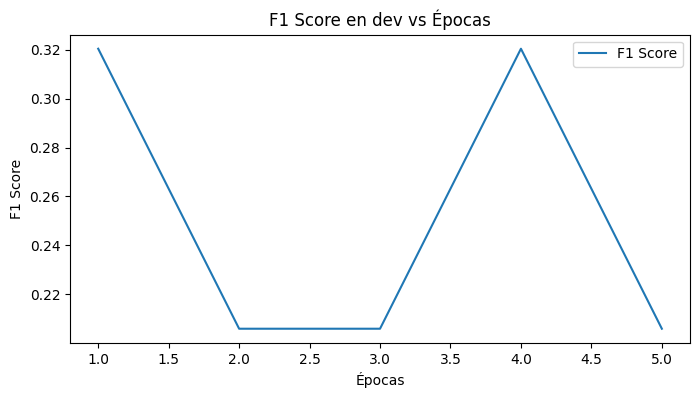

In [ ]:
# F1 score por cada epoca

plt.figure(figsize=(8, 4))
plt.plot(range(1, 5+1), f1_scores, label='F1 Score')
plt.xlabel('Épocas')
plt.ylabel('F1 Score')
plt.title('F1 Score en dev vs Épocas')
plt.legend()
#plt.grid(True)
plt.show()

### Preguntas

* Haz una hipótesis sobre por qué los resultados de BERT son mejores que los de otros modelos.

En mi primer intento tratando de utilizar BERT con el dataset de texto original en $X_{train},X_{dev}$ y $X_{tes}$ mi entrenamiento tardó considerablemte más que la MLP y la RNN, más de 1 hora durante 5 epocas y los resultados para el F1-Score en la data de validación son extraños(ver grafico superior).

* Cuál es la principal limitación de Word2Vec en comparación con BERT a nivel lingüístico al representar palabras? Propón un ejemplo.

Se tiene que Word2Vec produce representaciones fijas para cada palabra, sin considerar su contexto, mientras que BERT genera embeddings contextuales que cambian según las palabras que rodean a una palabra específica.

Un ejemplo es el siguiente :

"Robaron el banco dejando heridos graves"
"Me senté en un banco del parque."

BERT podría generar vectores que representen la palabra banco como una entidad financiera y como un lugar donde sentarse, es decir, no existiría solo un vector fijo.

* Visualiza los vectores del token `[CLS]` de BERT después del fine-tuning. Qué diferencias notas en comparación con antes?

* Qué sucede si utilizas un modelo diferente, como RoBERTa?